In [1]:
import h5py
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt

import dolfinx.plot as plot
from dolfinx.io import gmshio, XDMFFile
from dolfinx.fem import Function, FunctionSpace, VectorFunctionSpace
from dolfinx.mesh import (CellType, compute_midpoints, create_unit_cube,
                          create_unit_square, meshtags)
from dolfinx.geometry import (BoundingBoxTree, compute_colliding_cells,
                              compute_collisions)
from ufl import FiniteElement, VectorElement

from mpi4py import MPI
from petsc4py import PETSc

import sys
sys.path.insert(0, "../scripts")

from ns_2d_fenicsx import NSSplit

hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


In [2]:
mesh_file = "../mesh/branson-refined.msh"
ns = NSSplit(mesh_file, 
             dt=1e-3, 
             params=dict(mu=1e-3, rho=1000))
ns.setup_form()

output_file = "../outputs/branson-testing.h5"
output = h5py.File(output_file, "r")
u_dofs = output["/u_mean"][:]
p_dofs = output["/p_mean"][:]
t = output["/t"][:]
output.close()

ns.u_.x.array[:] = u_dofs[-1, :].copy()
ns.u_.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)

Info    : Reading '../mesh/branson-refined.msh'...
Info    : 11 entities
Info    : 6610 nodes
Info    : 3362 elements
Info    : Done reading '../mesh/branson-refined.msh'


(6610, 3)


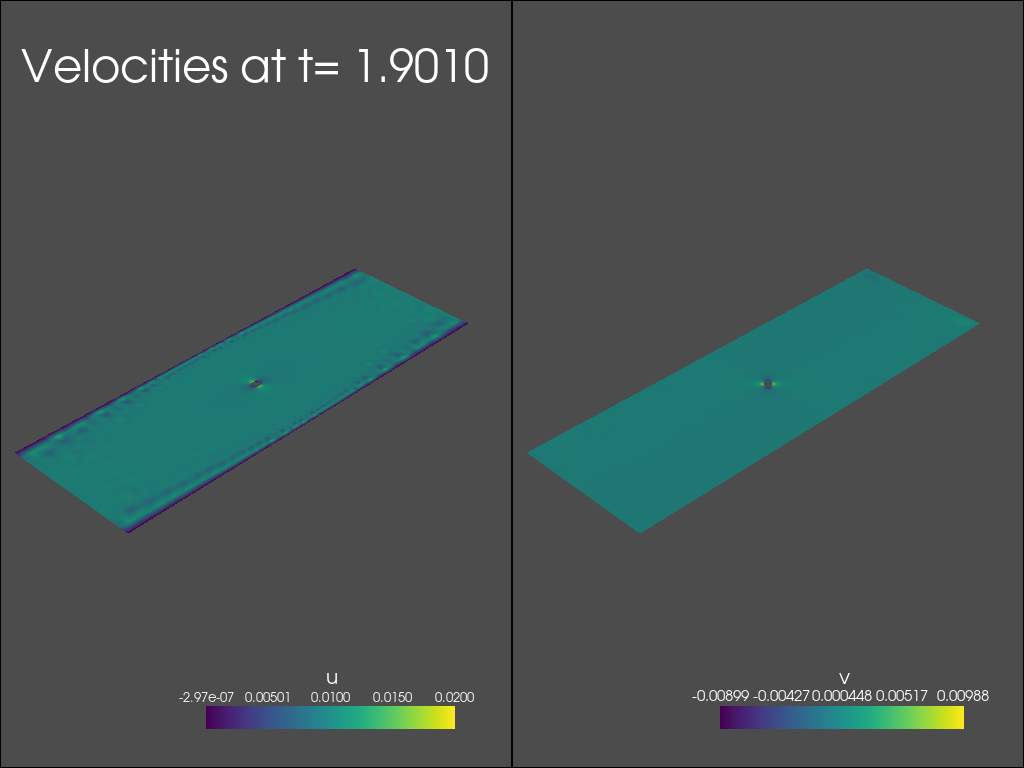

In [3]:
plotter = pv.Plotter(shape=(1, 2))
plotter.add_title(f"Velocities at t= {t[-1]:.4f}")

cells, cell_types, x = plot.create_vtk_mesh(ns.V)
grid = pv.UnstructuredGrid(cells, cell_types, x)

print(ns.V.tabulate_dof_coordinates().shape)

values = np.zeros((x.shape[0], 2), dtype=np.float64)
values[:, :ns.msh.topology.dim] = ns.u_.x.array.reshape(x.shape[0], ns.msh.topology.dim).real
grid.point_data["u"] = values

plotter.subplot(0, 0)
plotter.add_mesh(grid.copy(), component=0, show_edges=False, show_scalar_bar=True)
plotter.subplot(0, 1)
plotter.add_mesh(grid.copy(), component=1, show_edges=False, show_scalar_bar=False)
plotter.add_scalar_bar("v")
plotter.link_views()
plotter.camera_position = 'iso'
# plotter.background_color = 'white'
plotter.show(jupyter_backend="static")

In [4]:
print(ns.V_dof_coordinates.shape,
      ns.Q_dof_coordinates.shape)

(6610, 3) (1681, 3)
